# Read in/transform Data

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

path_to_project = os.path.abspath(os.path.join(os.getcwd(), '../'))    
sys.path.insert(1, os.path.join(path_to_project))

In [2]:
import itertools
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from src.data_dict import *
from src.utils import one_hot
from src.directory import data_dir, NHANES_preprocessed_filename
from src.estimators import aipw_estimator, unadjusted_DM_estimator, ipw_estimator, t_learner, s_learner, x_learner

In [3]:
# load df
NHANES_preprocessed_filepath = os.path.join(data_dir, NHANES_preprocessed_filename)
df = pd.read_csv(NHANES_preprocessed_filepath, index_col='SEQN')

In [4]:
# define relevant features
# features
z_col = light_col
t_col = sleep_deprivation_col
y_cols = [htn_col] # diastolic_col, systolic_col

# columns not to transform
all_cols = df.columns
untransformed_cols = [x for x in all_cols if x in [*y_cols, t_col, z_col]]

In [5]:
# prune df
df.dropna(how='any', inplace=True)
df = df.query(f'age >= {age_cutoff}')

## transform df
# apply scalers
scaler = StandardScaler()
numerical_transformation_cols = list(set(numerical_cols) - set(untransformed_cols))
df[numerical_transformation_cols] = scaler.fit_transform(df[numerical_transformation_cols])

# y_scaler = MinMaxScaler()
# df[y_cols] = y_scaler.fit_transform(df[y_cols])

# make z col binary (indicator of recommended max lux value during sleep)
light_cutoff = 1 # nightly minute-mean summed light exposure
df[z_col] = df[z_col].apply(lambda x: 1 if x <= light_cutoff else x)
df[z_col] = df[z_col].apply(lambda x: 0 if x > light_cutoff else x)

# one-hot encode multiclass categoricals
multiclass_cols = df[categorical_cols].columns[df[categorical_cols].nunique() > 2].tolist() 
categorical_transformation_cols = list(set(multiclass_cols) - set(untransformed_cols))
df = one_hot(df, categorical_transformation_cols)
df.columns = df.columns.str.replace('.0', '')

# get df as float
df = df.astype(float)

# except treatment
df[t_col] = df[t_col].astype(int)

# get covariates
x_cols = list(set(df.columns) - set([*y_cols, t_col, z_col]))

# update lists of variable type
all_cols = df.columns
categorical_cols = [x for x in df.columns if any([x.startswith(y) for y in categorical_cols])]

In [6]:
tau_pairs = [' vs '.join(x[::-1]) for x in itertools.combinations(df[t_col].unique().astype(str), 2)]

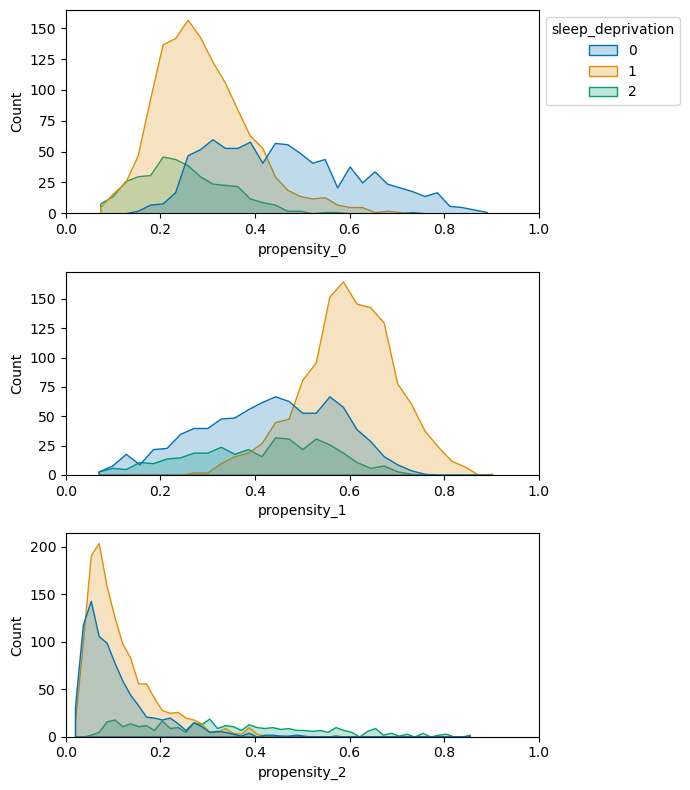

In [7]:
# check propensity balance
import matplotlib.pyplot as plt
import seaborn as sns
from src.estimators import propensity_estimator

fig, axs = plt.subplots(nrows=3, figsize=(7,8))
axs = axs.ravel()

propensity = propensity_estimator(df[x_cols], df[t_col], multiclass=True)['pi']
propensity_cols = [f'propensity_{i}' for i in range (propensity.shape[1])]

plot_df = df.copy()
plot_df[propensity_cols] = propensity

for i, x in enumerate(propensity_cols):
    legend = True if i == 0 else False
    sns.histplot(
        data=plot_df, 
        x=x, 
        hue="sleep_deprivation", 
        palette='colorblind', 
        ax=axs[i],
        legend=legend, 
        element='poly' # poly == vertices centered in bin
    )
    if legend:
        sns.move_legend(axs[i], "upper left", bbox_to_anchor=(1, 1))
    
    axs[i].set(xlim=[0,1])
    
plt.tight_layout()

# Non-Deep Learning Estimators

In [8]:
# created propensity score matched df
from src.utils import propensity_score_matching_multiclass, love_plot_multiclass_abs_compare

psm_df = propensity_score_matching_multiclass(df, t_col, x_cols)

In [9]:
# calculate prevalence of HTN between groups
for i in range(3):
    print(f'Group {i} HTN prevalence:', psm_df.loc[psm_df['sleep_deprivation']==i, 'HTN'].sum() / len(psm_df['sleep_deprivation']==i))

Group 0 HTN prevalence: 0.1906793567443387
Group 1 HTN prevalence: 0.2205447981621267
Group 2 HTN prevalence: 0.23252379389563504


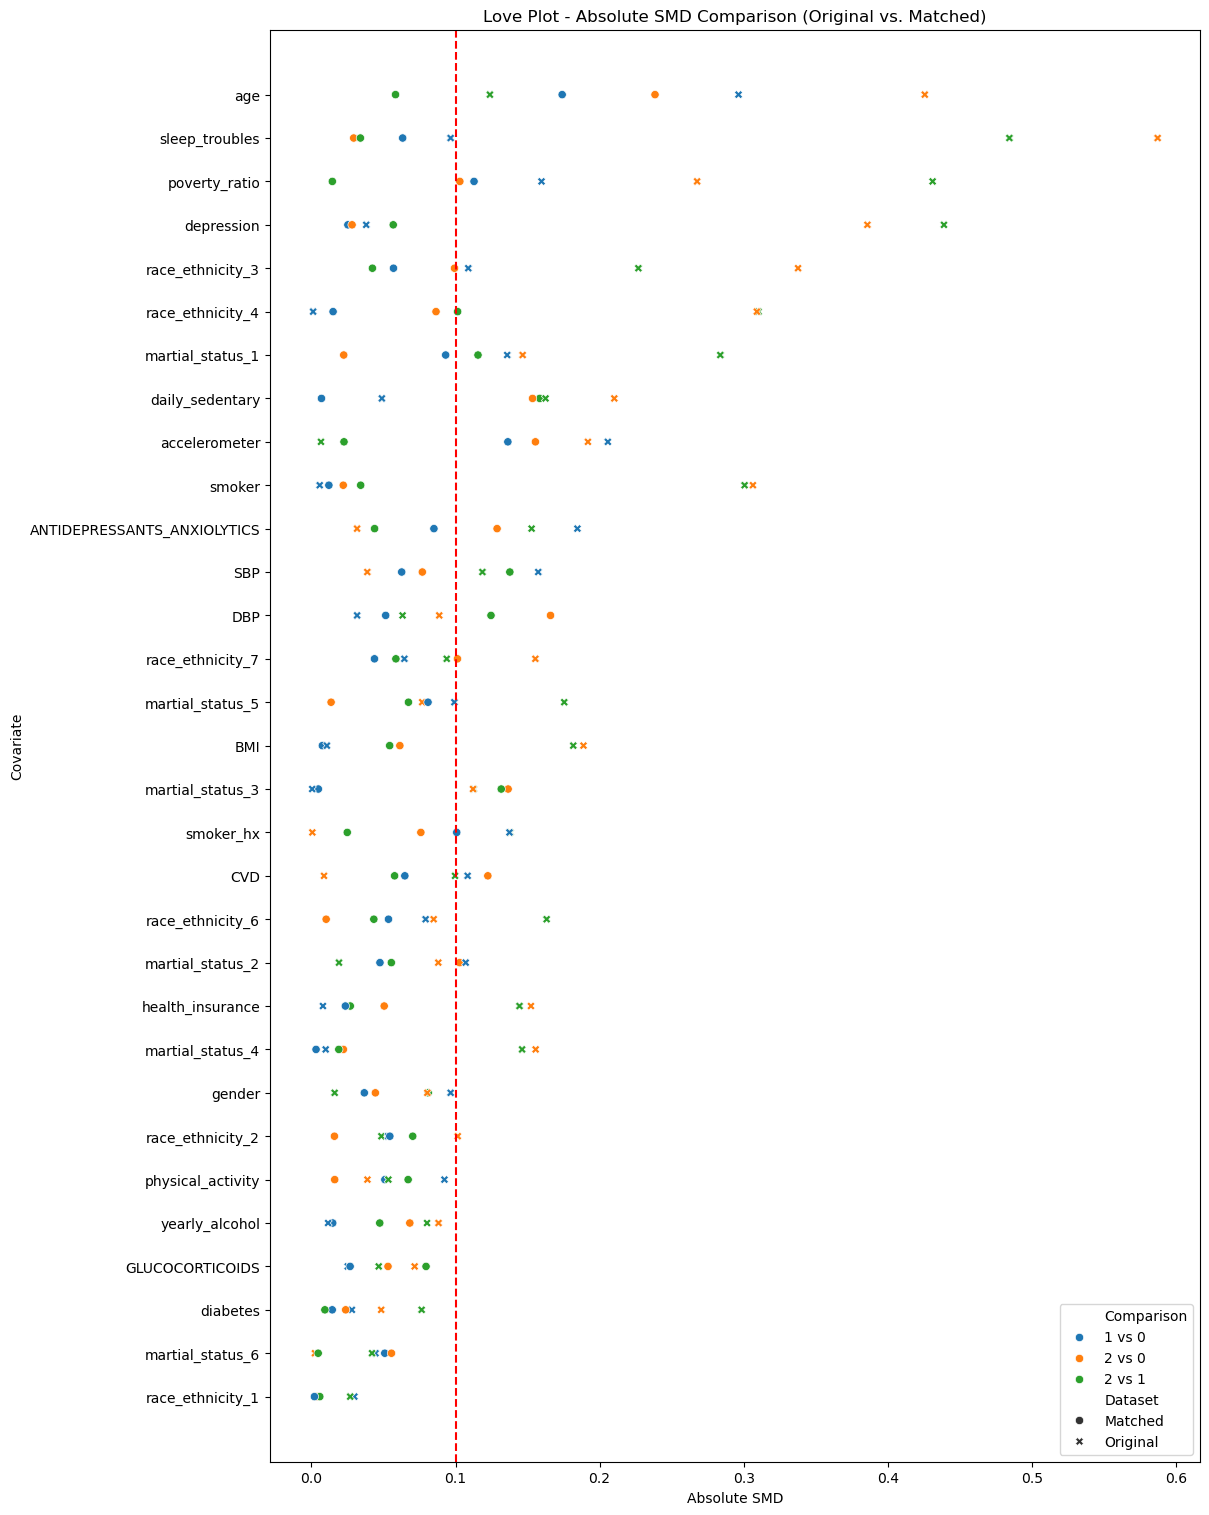

In [10]:
# Check balance between treatment groups in propensity matched vs. original dataset
love_plot_multiclass_abs_compare(df, psm_df, t_col, x_cols)

In [11]:
estimators = [aipw_estimator] # unadjusted_DM_estimator, ipw_estimator, t_learner, s_learner, x_learner
estimator_names = estimator_names = [x.__name__ for x in estimators]
index = pd.MultiIndex.from_product([estimator_names, tau_pairs, y_cols], names=['estimator', 'pair','outcome'])
tau_results = pd.DataFrame(index=index, columns=['tau', 'propensity_model_score', 'outcome_model_score'])

In [12]:
for tau_estimator, outcome in itertools.product(estimators, y_cols):
    estimator_name = tau_estimator.__name__
    print(f'Estimating effect of {t_col} on {outcome} using {estimator_name}...')
    continuous_outcome = False if outcome == 'HTN' else True
    results = tau_estimator(psm_df, 
                            treatment_var=t_col,
                            outcome_var=outcome, 
                            covariates=x_cols,
                            continuous_outcome=continuous_outcome)
    
    for pair in results.keys():
        tau = results[pair]['tau']
        propensity_model_score = results[pair]['propensity_model_score']
        outcome_model_score = results[pair]['outcome_model_score']
        tau_results.loc[(estimator_name, pair, outcome)] = tau, propensity_model_score, outcome_model_score

Estimating effect of sleep_deprivation on HTN using aipw_estimator...


In [13]:
tau_results

tau propensity_model_score  \
estimator      pair   outcome                                    
aipw_estimator 1 vs 0 HTN     -0.010954               0.747457   
               2 vs 0 HTN      0.003556               0.747457   
               2 vs 1 HTN      0.014509               0.747457   

                              outcome_model_score  
estimator      pair   outcome                      
aipw_estimator 1 vs 0 HTN                0.933869  
               2 vs 0 HTN                0.933869  
               2 vs 1 HTN                0.933869

# Deep Learning Estimators

In [8]:
import pandas as pd
from src.lightning_pipelines import DragonNet_training_pipeline

Seed set to 40


In [9]:
# set training variables & labels
dataset_name = 'NHANES'
model_name = 'DragonNet'
treatment_col = t_col
n_treatment_groups = df[treatment_col].nunique()
outcome_cols = y_cols
input_features = x_cols
input_dim = len(input_features)

# hyperparamters
alpha = 1.0
beta = 1.0
max_epochs = 300
patience = 5  # for early stopping
target_regs = [True] # False
learning_rates = {htn_col:1e-4, systolic_col:3e-4, diastolic_col:3e-4}

# logging params
wandb_kwargs = dict(project_name='CPH_200B', 
                    wandb_entity='furtheradu', 
                    dir_path='notebooks/..',
                    offline=False)

In [10]:
# set up results dataframe
target_reg_str = {True:'_target_reg', False:''}
estimator_names = [f'{model_name}{target_reg_str[x]}' for x in target_regs]
index = pd.MultiIndex.from_product([estimator_names, tau_pairs, outcome_cols], names=['estimator', 'pair','outcome'])
dragon_tau_results = pd.DataFrame(index=index, columns=['tau']).sort_index()

In [11]:
for target_reg, outcome_col in itertools.product(target_regs, outcome_cols):
    print(f'Training model {model_name} on {dataset_name} with target_reg == {target_reg} to predict CATE of {treatment_col} on {outcome_col}')    
    pipeline_out = DragonNet_training_pipeline(
        raw_data=df,
        model_name=model_name,
        treatment_col=treatment_col,
        outcome_col=outcome_col,
        input_features=input_features,
        dataset_name=dataset_name,
        alpha=alpha,
        beta=beta,
        target_reg=target_reg,
        wandb_kwargs=wandb_kwargs,
        n_treatment_groups=n_treatment_groups,
        max_epochs=max_epochs,
        learning_rate=learning_rates[outcome_col],
        patience=patience
    )

    trainer, model, datamodule = [pipeline_out[x] for x in ['trainer', 'model', 'datamodule']]
    
    print("Testing model")
    test_pred = trainer.test(model, datamodule)[0]
    
    # log results to df
    estimator_name = f'{model_name}{target_reg_str[target_reg]}'
    for pair in tau_pairs:
        dragon_tau_results.loc[(estimator_name, pair, outcome_col), 'tau'] = test_pred[f'test_tau_{pair}']
        dragon_tau_results.loc[(estimator_name, pair, outcome_col), 'se'] = test_pred[f'test_se_{pair}']
        dragon_tau_results.loc[(estimator_name, pair, outcome_col), 'propensity_model_bal_acc'] = test_pred[f'test_propensity_model_bal_acc']
        dragon_tau_results.loc[(estimator_name, pair, outcome_col), 'rr'] = test_pred[f'test_rr_{pair}']
        dragon_tau_results.loc[(estimator_name, pair, outcome_col), 'e'] = test_pred[f'test_e_value_{pair}']
        
        for k in [x for x in test_pred.keys() if x.startswith('outcome_model')]:
            dragon_tau_results.loc[(estimator_name, pair, outcome_col), k] = test_pred[k]


    print(f'Finished training.\n\n')

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model DragonNet on NHANES with target_reg == True to predict CATE of sleep_deprivation on HTN
Training model


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/hentipapai/.netrc
wandb: Currently logged in as: furtheradu to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Processing NHANES Dataset: 2547it [00:00, 15806.51it/s]
/home/hentipapai/miniconda3/envs/cph200b_project3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b-project3/logs/DragonNet/version_10 exists and is not empty.

  | Name         | Type           | Params | Mode 
--------------------------------------------------------
0 | outcome_loss | BCELoss        | 0      | train
1 | model        | DragonNetTorch | 118 K  | train
--------------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.476     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing NHANES Dataset: 2547it [00:00, 10520.93it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       outcome_model_0_acc              0.8019607663154602
       outcome_model_1_acc              0.7980391979217529
       outcome_model_2_acc              0.7784313559532166
      test_dragon_net_loss               1.525655922133605
       test_e_value_1 vs 0              1.3820223808288574
       test_e_value_2 vs 0              1.9283850193023682
       test_e_value_2 vs 1              1.6953365802764893
            test_loss                   1.7294036493465075
  test_propensity_model_bal_acc         0.36927247047424316
         test_rr_1 vs 0                 0.9235904812812805
         test_rr_2 vs 0                 0.7682238221168518
         test_rr_2 vs 1                 0.8317797183

In [12]:
dragon_tau_results.dropna(how='all')

tau        se  \
estimator            pair   outcome                       
DragonNet_target_reg 1 vs 0 HTN     -0.051644  0.005308   
                     2 vs 0 HTN     -0.156654  0.005326   
                     2 vs 1 HTN      -0.10501  0.005319   

                                     propensity_model_bal_acc        rr  \
estimator            pair   outcome                                       
DragonNet_target_reg 1 vs 0 HTN                      0.369272  0.923590   
                     2 vs 0 HTN                      0.369272  0.768224   
                     2 vs 1 HTN                      0.369272  0.831780   

                                            e  outcome_model_0_acc  \
estimator            pair   outcome                                  
DragonNet_target_reg 1 vs 0 HTN      1.382022             0.801961   
                     2 vs 0 HTN      1.928385             0.801961   
                     2 vs 1 HTN      1.695337             0.801961   

                                     outcome_model_1_acc  outcome_model_2_acc  
estimator            pair   outcome                                            
DragonNet_target_reg 1 vs 0 HTN                 0.798039             0.778431  
                     2 vs 0 HTN                 0.798039             0.778431  
                     2 vs 1 HTN                 0.798039             0.778431

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_points_with_ci(df, x_col='x', y_col='y', se_col='se', title='Points with Confidence Intervals', x_label='X Axis', y_label='Y Axis', output_path='plot.png'):
    """
    Plots points with confidence intervals using Seaborn and Times New Roman font,
    with a grid and a gray dashed line for y = 0.

    Args:
        df (pd.DataFrame): DataFrame containing x, y, and standard error columns.
        x_col (str): Name of the x-value column.
        y_col (str): Name of the y-value column.
        se_col (str): Name of the standard error column.
        title (str): Title of the plot.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        output_path (str): Path to save the plot.
    """

    # Calculate confidence interval bounds (assuming 95% CI)
    df['lower'] = df[y_col] - 1.96 * df[se_col]
    df['upper'] = df[y_col] + 1.96 * df[se_col]

    # # Set Times New Roman font for all text
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']   

    # Create the plot
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.scatterplot(x=x_col, y=y_col, data=df, color='black') # plot the points
    plt.errorbar(x=df[x_col], y=df[y_col], yerr=1.96 * df[se_col], fmt='none', color='black', capsize=5) # plot the error bars.

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.5)

    # Add gray dashed line for y = 0
    plt.axhline(y=0, color='gray', linestyle='--')

    # Set labels and title
    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)

    # Save the plot
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

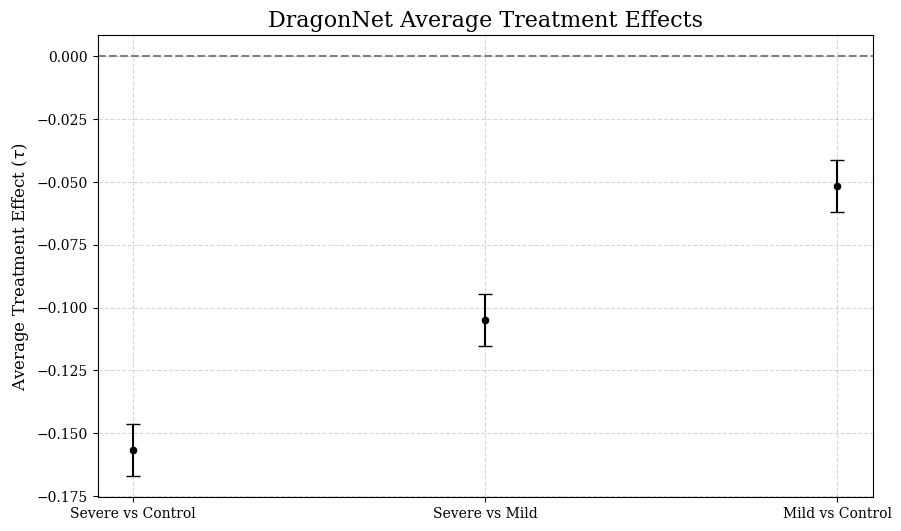

In [36]:
plot_df = dragon_tau_results.reset_index().sort_values(by='tau', ascending=True)
plot_df['pair'] = plot_df['pair'].replace({'2':'Severe', '1':'Mild', '0':'Control'}, regex=True)

plot_points_with_ci(plot_df, 
                    x_col='pair',
                    y_col='tau',
                    se_col='se',
                    x_label='',
                    title='DragonNet Average Treatment Effects',
                    y_label=r'Average Treatment Effect ($\tau$)',
                    output_path='../figures/DragonNet_ATE.png')